В данном проекте рассмотрен датасет [E-Commerce Data](https://www.kaggle.com/datasets/carrie1/ecommerce-data)

Цели:
- Получить инсайты о продажах, клиентах и товарах, чтобы улучшить маркетинг, запасы и прибыль
- Применить EDA, статистику и ML-инструменты для извлечения знаний из данных и валидации гипотез
- Понять, какие товары приносят больше всего денег
- Определить сегменты клиентов, которые приносят основную прибыль
- Оценить динамику продаж — есть ли сезонность, пики, падения
- Выяснить, какие категории товаров стоит продвигать или исключить

### **Импорт библиотек**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.max_columns', 100)

df = pd.read_csv('../data/data.csv', encoding='ISO-8859-1')

df.head

<bound method NDFrame.head of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerI

### **Предобработка данных**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [12]:
df = df.dropna(subset=['CustomerID'])

В датасете присутствуют возвраты. Их надо удалить для избежания искажения аналитики

In [13]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [14]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [15]:
df[['Quantity', 'UnitPrice', 'TotalPrice']].describe()

,Quantity,UnitPrice,TotalPrice
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,22.394749
std,180.420210,22.096788,309.055588
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,4.680000
50%,6.000000,1.950000,11.800000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000


### **EDA**

In [20]:
print(f"Количество уникальных заказов: {df['InvoiceNo'].nunique()}")
print(f"Количество уникальных клиентов:, {df['CustomerID'].nunique()}")
print(f"Общая выручка: {df['TotalPrice'].sum()}")

Количество уникальных заказов: 18536
Количество уникальных клиентов:, 4339
Общая выручка: 8911407.904


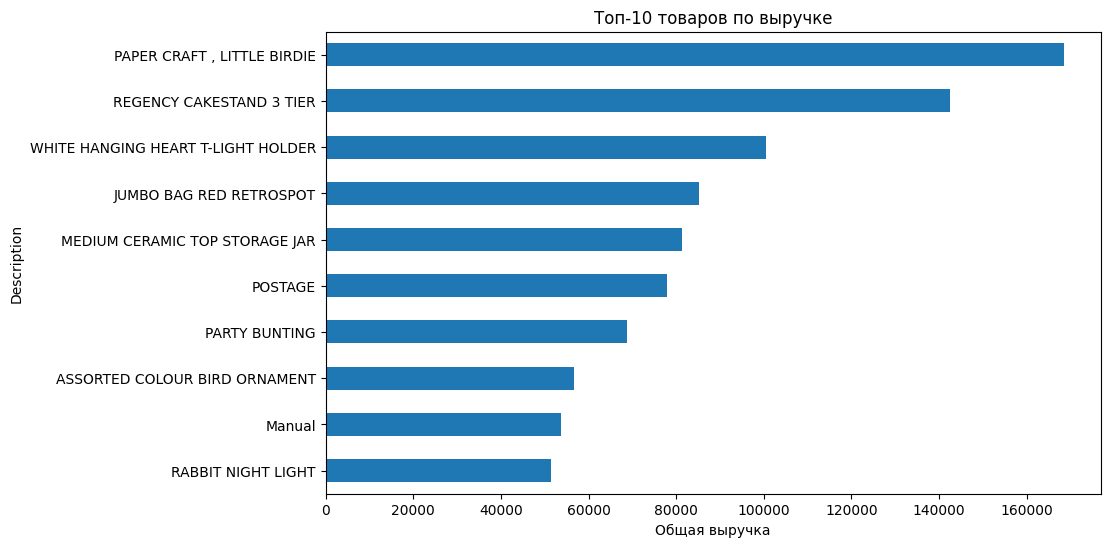

In [21]:
top_products = (
    df.groupby('Description')['TotalPrice']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
top_products.plot(kind='barh', figsize=(10, 6))
plt.title('Топ-10 товаров по выручке')
plt.xlabel('Общая выручка')
plt.gca().invert_yaxis()
plt.show()

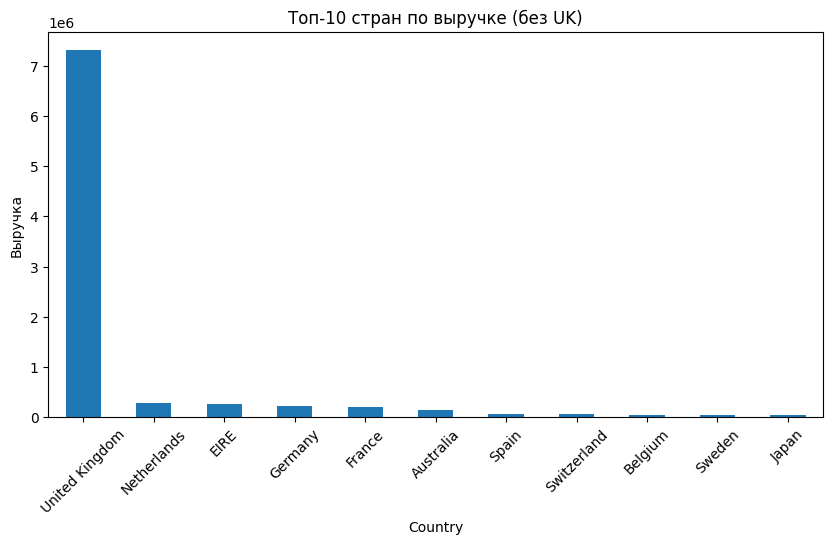

In [24]:
country_revenue = (
    df.groupby('Country')['TotalPrice']
    .sum()
    .sort_values(ascending=False)
)

# Исключим UK (она ~95% данных) и покажем топ-10 остальных
country_revenue[0:11].plot(kind='bar', figsize=(10, 5))
plt.title('Топ-10 стран по выручке (без UK)')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.show()


Исключим UK (она ~95% данных) и покажем топ-10 остальных, не то график неинформативен

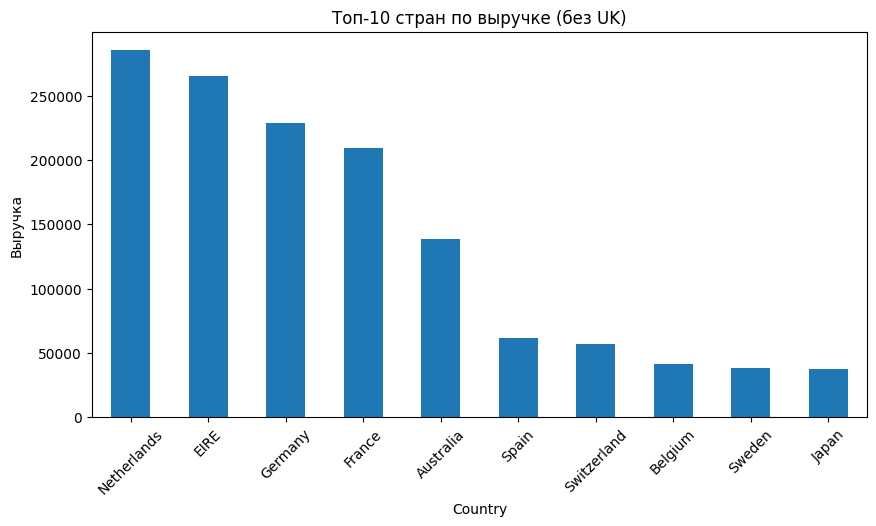

In [23]:
country_revenue = (
    df.groupby('Country')['TotalPrice']
    .sum()
    .sort_values(ascending=False)
)

country_revenue[1:11].plot(kind='bar', figsize=(10, 5))
plt.title('Топ-10 стран по выручке (без UK)')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.show()


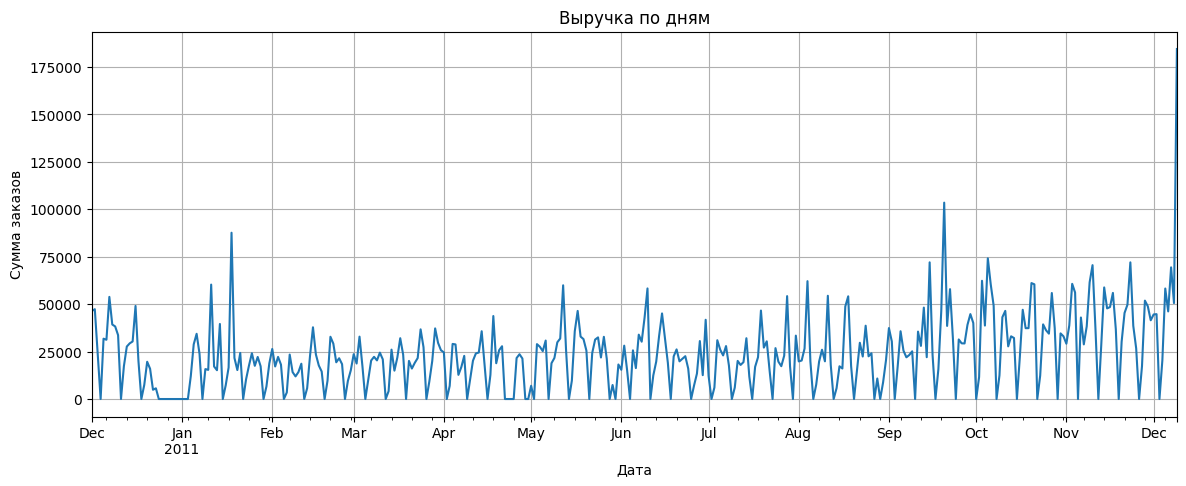

In [25]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # если ещё не сделали
daily_revenue = df.set_index('InvoiceDate').resample('D')['TotalPrice'].sum()

plt.figure(figsize=(14, 5))
daily_revenue.plot()
plt.title('Выручка по дням')
plt.xlabel('Дата')
plt.ylabel('Сумма заказов')
plt.grid(True)
plt.show()


### **Статистический анализ и проверка гипотез**

**Гипотезы:**

*№1. Средний чек в Великобритании выше, чем в других странах*

    - H0: Средние чеки одинаковые
    - Н1: Средний чек в UK выше, чем за её пределами
*№2. Средний чек новых клиентов ниже, чем у постоянных*

    - Пусть клиенты с 1 заказом "новые", остальные - "постоянные"
    - H0: средний чек одинаков
    - Н1: новые тратят меньше
*№3. Разброс (стандартное отклонение) цен выше у дорогих товаров*

    - Сравнить std цены между товарами с UnitPrice > 10 и остальными
    - Построить доверительные интервалы и сравнить, где разброс больше


### Гипотеза №1

Группируем по заказам: средний чек = TotalPrice / кол-во заказов. Создадим таблицу: заказ — страна — сумма заказа

In [26]:
orders = df.groupby(['InvoiceNo', 'Country'])['TotalPrice'].sum().reset_index()
uk_orders = orders[orders['Country'] == 'United Kingdom']['TotalPrice']
non_uk_orders = orders[orders['Country'] != 'United Kingdom']['TotalPrice']

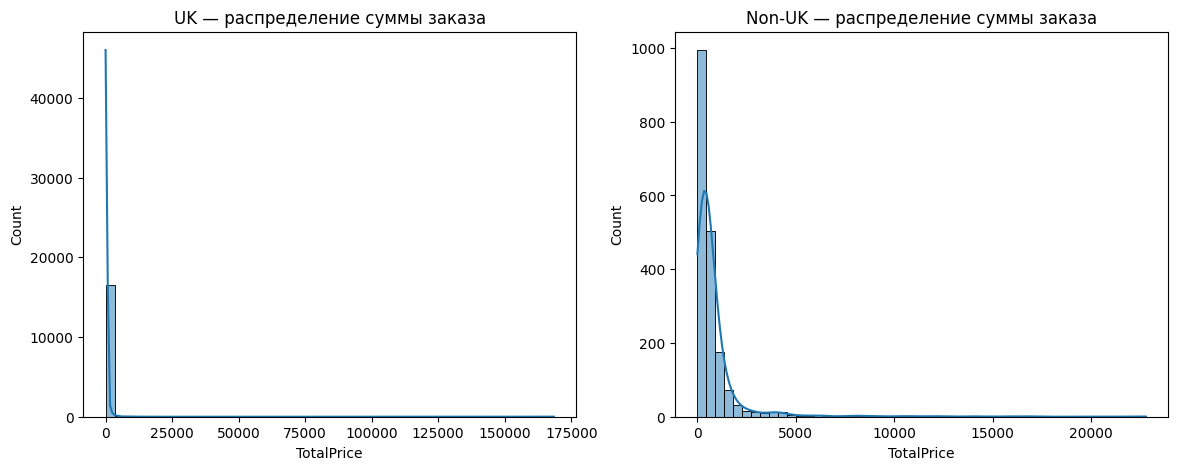

In [27]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(uk_orders, bins=50, kde=True)
plt.title('UK — распределение суммы заказа')

plt.subplot(1, 2, 2)
sns.histplot(non_uk_orders, bins=50, kde=True)
plt.title('Non-UK — распределение суммы заказа')

plt.show()


Использовать классический t-тест нежелательно ибо распределения не нормальные

In [36]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(uk_orders, non_uk_orders, alternative='greater')

print(f"U-критерий: {stat:.2f}, p-value: {p:.4f}")

U-критерий: 11293264.50, p-value: 1.0000


p-value > 0.05, значит нет оснований отклонять H0, разница незначима

In [37]:
import scipy.stats as stats

def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)
    margin = sem * stats.t.ppf((1 + confidence) / 2, len(data)-1)
    return mean - margin, mean + margin

uk_ci = confidence_interval(uk_orders)
non_uk_ci = confidence_interval(non_uk_orders)

print(f"Доверительный интервал UK: {uk_ci}")
print(f"Доверительный интервал Non-UK: {non_uk_ci}")


Доверительный интервал UK: (np.float64(413.70085320410647), np.float64(464.2367471322501))
Доверительный интервал Non-UK: (np.float64(770.0302321667333), np.float64(928.9802076848831))


Разброс не пересекается и средние значения сильно отличаются. Значит есть статистически значимая разница
У клиентов вне Великобритании чеки выше, а сами британцы делают больше заказов, но на меньшие суммы

Это мб связано с тем, что экспорт производится оптовыми сделками. Или с высокой стоимостью достави, из-за чего приходится заказывать партиями

In [39]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(uk_orders, non_uk_orders, alternative='less')  # в UK — меньше, чем за пределами (на основе доверительных интервалов)

print(f"U-критерий: {stat:.2f}, p-value: {p:.4f}")

U-критерий: 11293264.50, p-value: 0.0000


In [40]:
print("less: ", mannwhitneyu(uk_orders, non_uk_orders, alternative='less').pvalue)
print("greater: ", mannwhitneyu(uk_orders, non_uk_orders, alternative='greater').pvalue)
print("two-sided: ", mannwhitneyu(uk_orders, non_uk_orders, alternative='two-sided').pvalue)


less:  1.1995349892546701e-89
greater:  1.0
two-sided:  2.3990699785093402e-89


- Разница между UK и Non-UK огромная и статистически значимая
- Средний чек у зарубежных клиентов существенно выше, чем у британских